# Style Transfer with Convolutional Neural Networks

In [59]:
import torchvision.models as models
from importlib import reload
import torch
import numpy as np
from torch.optim import LBFGS
import torch.nn as nn
from __future__ import print_function
import utils as U;reload(U)
from torch.autograd import Variable
import torch.optim as optim
import torch.autograd as autograd

import matplotlib.pyplot as plt
import pdb
import copy

%matplotlib inline

# Loss functions

In [60]:
vgg = models.vgg16(pretrained=True)

## Content Loss

### Content Image

# Content Loss

In [61]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()        
        self.target = target.detach()
        self.loss_fn = nn.MSELoss()
    
    def forward(self, input):
        self.loss = self.loss_fn(input, self.target)
        self.output = input.clone()
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss


<PIL.Image.Image image mode=RGB size=224x224 at 0x7F87D80717B8>


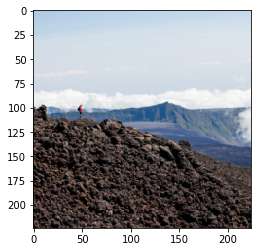

In [86]:
content_image = Variable(U.get_image(4, None, 112))
content_image = content_image.cuda()
U.imshow(content_image.data)

In [119]:
selected_convolutional_indexes = [28]

def build_model(cnn):
    content_losses = []
    model = nn.Sequential()
    cnn = copy.deepcopy(cnn).cuda()
    for index, layer in enumerate(cnn.features):
        layer_set = False   
        if type(layer) is nn.ReLU:
            layer_set = True
            model.add_module("layer_{}_relu".format(index ), layer)
            
            if index - 1 in selected_convolutional_indexes:
                #should I be cloning this?            
                content_target = model(content_image.unsqueeze(0)).clone()
                content_loss = ContentLoss(content_target)
                content_losses.append(content_loss)
                model.add_module("layer_{}_content_loss_relu".format(index), content_loss)
                        

        if type(layer) is nn.MaxPool2d:
            layer_set = True
            avg_pool = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding = layer.padding)
            model.add_module("layer_{}".format(index), avg_pool)
        if not layer_set:
            model.add_module("layer_{}".format(index), layer)
    modeul = model.cuda()
    return model, content_losses

In [128]:
print(vgg.features)
print("========")
print(model.modules)
#model, c_losses = build_model(vgg)

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU (inplace)
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU (inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU (inplace)
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU (inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU (inplace)
  (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU (inplace)
  (19): Conv2d(512,

In [121]:
import pdb
import time
class Runner():
    def __init__(self, model, optimizer, c_losses, gen_image):
        self.optimizer = optimizer
        self.model = model
        self.c_losses = c_losses
        self.gen_image = gen_image
        self.count = 0
        self.content_loss = 0

    def loss_fn(self):
        self.gen_image.data.clamp_(0,1)
        self.optimizer.zero_grad()
        self.count += 1
        prediction = self.gen_image.unsqueeze(0)
        model(prediction)
        
        c_loss = 0
        for c in self.c_losses:
            c_loss = c.backward()
        self.content_loss = c_loss
        flattened_img = self.gen_image.grad.view(self.gen_image.nelement()).data            
        max_grad = flattened_img.max()
        min_grad = flattened_img.min()
        print("Iteration: {} Loss: {} Grads: ({}...{})".format(self.count,c_loss.data[0], min_grad, max_grad))

        #self.optimizer.zero_grad()
        return self.content_loss


In [122]:
def run_epochs(count, runner, gen_image):
    for i in range(count):
        ttl_loss = runner.optimizer.step(runner.loss_fn).data[0]
        content_loss = runner.content_loss[0].data[0]
        if i % 10 == 0:
            print("Epoch #{} Content Loss: {} vs Loss By Optimizer {}".format(str(i), content_loss, ttl_loss))
    gen_image.data.clamp_(0,1)

In [123]:
from scipy.optimize import fmin_l_bfgs_b 
noise_tensor = torch.rand(3,224, 224)
gen_image = nn.Parameter(noise_tensor)
gen_image = gen_image.cuda().clone().detach()
gen_image.requires_grad = True
optimizer = LBFGS([gen_image], lr=0.1)
runner = Runner(model, optimizer, c_losses, gen_image)


In [124]:
run_epochs(240, runner, gen_image)

Stepping
Iteration: 1 Loss: 0.014560774900019169 Grads: (-2.2189749870449305e-05...2.7378722734283656e-05)
Iteration: 2 Loss: 0.014560667797923088 Grads: (-2.2187026843312196e-05...2.7377049264032394e-05)
Iteration: 3 Loss: 0.014560559764504433 Grads: (-2.218606459791772e-05...2.7375361241865903e-05)
Iteration: 4 Loss: 0.014560452662408352 Grads: (-2.2185124180396087e-05...2.7373705961508676e-05)
Iteration: 5 Loss: 0.014560345560312271 Grads: (-2.218417102994863e-05...2.7372021577320993e-05)
Iteration: 6 Loss: 0.01456023845821619 Grads: (-2.218321787950117e-05...2.7370351745048538e-05)
Iteration: 7 Loss: 0.01456013135612011 Grads: (-2.218227382400073e-05...2.7368678274797276e-05)
Iteration: 8 Loss: 0.014560023322701454 Grads: (-2.2181317035574466e-05...2.7366981157683767e-05)
Iteration: 9 Loss: 0.014559916220605373 Grads: (-2.2180356609169394e-05...2.7365324058337137e-05)
Iteration: 10 Loss: 0.014559808187186718 Grads: (-2.208183468610514e-05...2.736365786404349e-05)
Iteration: 11 Loss

## Layer 0
* 372 epochs 
* Slowly keeps optimizing
* Loss: 0.0924733579158783 
* Grads: (-2.1387504602898844e-05...1.8031461877399124e-05)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F8828748E80>


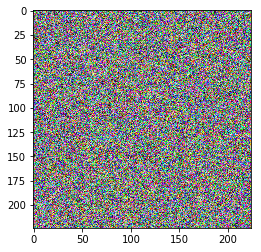

In [85]:
U.imshow(gen_image.data)

## Layer 2
* 120 Epochs
* Stops optimizing because loss before /after run are the same
* Loss: 0.8337880969047546 
* Grads: (-0.00022660808463115245...0.00019339038408361375)
abs(loss - prev_loss) < tolerance_change, abs(0.8337880969047546 - 0.8337880969047546) < tolerance_change

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F886E790588>


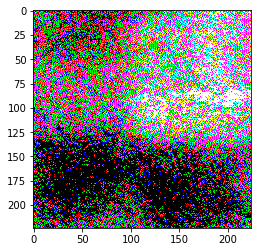

In [94]:
U.imshow(gen_image.data)

## Layer 5
* 240 epochs
* Keeps optimizing
* Loss 0.00022031097614672035 
* Grads: (-1.8796744143401156e-06...2.588792312963051e-06)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F87D0E61FD0>


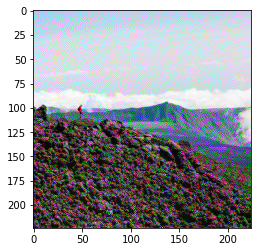

In [103]:
U.imshow(gen_image.data)

## Layer 7
* 240 Epochs
* Keeps optimizing
* Loss: 6.82948884787038e-05 
* Grads: (-2.3504615001002094e-06...2.4992496037157252e-06)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F8808421CF8>


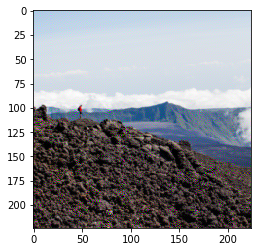

In [111]:
U.imshow(gen_image.data)

## Layer 10
* 240 Epochs
* Keeps optimizing
* Loss: 0.0001233584771398455 
* Grads: (-1.2731295555568067e-06...1.297421590606973e-06)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F88813AAF28>


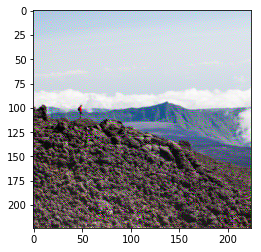

In [118]:
U.imshow(gen_image.data)

## Layer 24
* 240 Epochs
* Gets "Stuck"
* Around epoch 35: 
    * Iteration: 735 Loss: 3.581315831979737e-05 Grads: (-4.2941801439155824e-06...4.966177584719844e-06)
    * Iteration: 736 Loss: 0.012184136547148228 Grads: (-3.071042738156393e-05...2.386943560850341e-05)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F87E401FCF8>


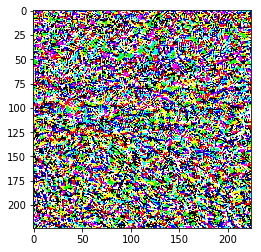

In [125]:
U.imshow(gen_image.data)